# Facebook Prophet - Lab

## Introduction

In the last lab, you learned how to visualize and manipulate time series data, and how to use ARIMA modeling to produce forecasts for time series data. You also learned how to conclude a correct parametrization of ARIMA models. This can be a complicated process, and while statistical programming languages such as R provide automated ways to solve this issue, those have yet to be officially ported over to Python. 

Fortunately, the Data Science team at Facebook recently published a new library called `fbprophet`, which enables data analysts and developers alike to perform forecasting at scale in Python. We encourage you to read [this article](https://research.fb.com/prophet-forecasting-at-scale/) by Facebook explaining how `fbprophet` simplifies the forecasting process and provides an improved predictive ability. 

## Objectives

- Model a time series using the Facebook's Prophet 
- Describe the difference between ARIMA and Additive Synthesis for time series forecasting 
- Use the methods in the `fbprophet` library to plot predicted values 

## Facebook's Prophet

Facebook's `prophet` uses an elegant yet simple method for analyzing and predicting periodic data known as the **additive modeling**. The idea is straightforward: represent a time series as a combination of patterns at different scales such as daily, weekly, seasonally, and yearly, along with an overall trend. Your energy use might rise in the summer and decrease in the winter, but have an overall decreasing trend as you increase the energy efficiency of your home. An additive model can show us both patterns/trends and make predictions based on these observations.

The following image shows an additive model decomposition of a time series into an overall trend, yearly trend, and weekly trend.

![](https://research.fb.com/wp-content/uploads/2017/02/prophet_example_for_post2.png?w=648)

*“Prophet has been a key piece to improving Facebook’s ability to create a large number of trustworthy forecasts used for decision-making and even in product features.”*

In order to compute its forecasts, the `fbprophet` library relies on the STAN programming language. Before installing `fbprophet`, you need to make sure that the `pystan` Python wrapper to STAN is installed. We shall first install `pystan` and `fbprophet` using `pip install`.

In [1]:
# # If installing from terminal
# pip install pystan
# pip install fbprophet

# # If installing from a jupyter notebook
# !pip install pystan
# !pip install fbprophet

Let's start by reading in our time series data. We will cover some data manipulation using `pandas`, accessing financial data using the `Quandl` library, and plotting with `matplotlib`. 

In [25]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from jupyterthemes import jtplot
jtplot.reset() 
plt.style.use(['fivethirtyeight','bmh'])
# jtplot.style(theme='monokai', context='notebook', ticks='True', grid='False')

from matplotlib.pylab import rcParams
SIZE = 'small'
# COLOR = 'k'
# rcParams['text.color'] = COLOR
# rcParams['axes.labelcolor'] = COLOR
# rcParams['xtick.color'] = COLOR
# rcParams['ytick.color'] = COLOR
rcParams['axes.labelsize']= SIZE
rcParams['xtick.labelsize']= SIZE
rcParams['ytick.labelsize']= SIZE
# rcParams['grid.color']= 'white'

from fbprophet import Prophet as proph

The `fbprophet` library also imposes the strict condition that the input columns be named `ds` (the time column) and `y` (the metric column), so let's rename the columns in our `ts` DataFrame. 

In [3]:
# Import passengers.csv and set it as a time series
df = pd.read_csv('./passengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)
df

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


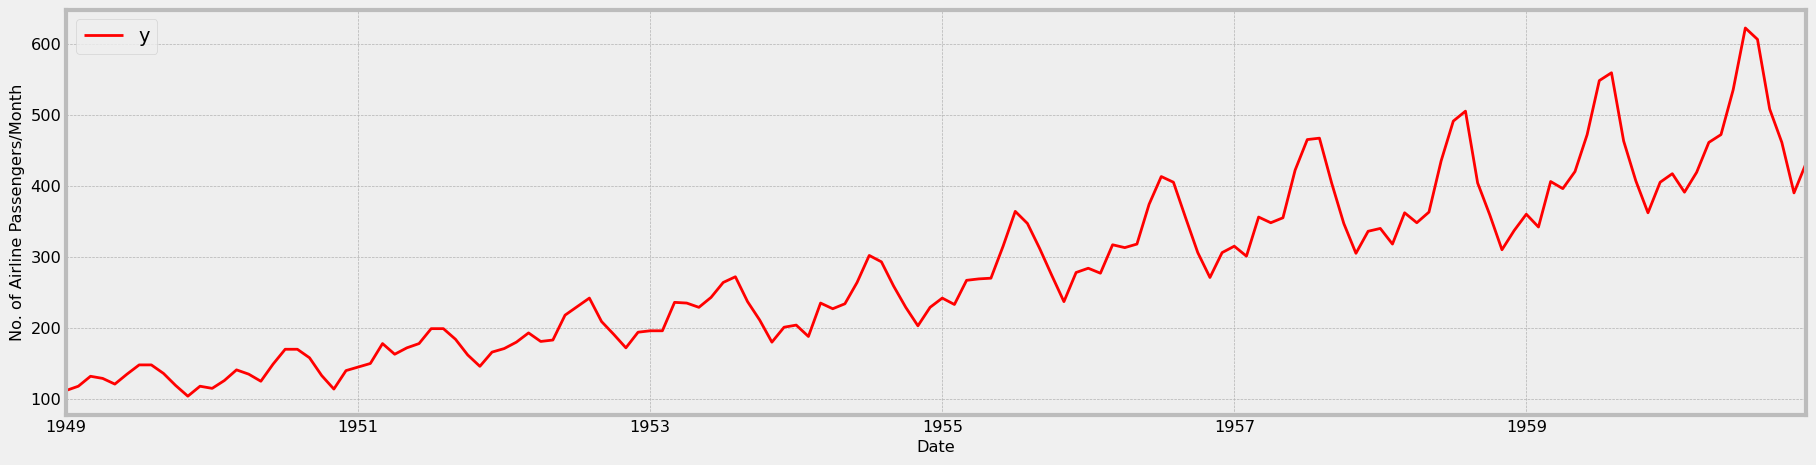

In [29]:
# Plot the timeseries
df.set_index('ds').plot(figsize=(20, 5),color='r')
plt.xlabel('Date')
plt.ylabel('No. of Airline Passengers/Month')
plt.show()

## Time Series Forecasting with Prophet

We will now learn how to use the `fbrophet` library to predict future values of our time series. The Facebook team has abstracted away many of the inherent complexities of time series forecasting and made it more intuitive for analysts and developers alike to work with time series data.

To begin, we will create a new prophet object with `Prophet()` and provide a number of arguments. For example, we can specify the desired range of our uncertainty interval by setting the `interval_width` parameter.

In [5]:
# Set the uncertainty interval to 95% (the Prophet default is 80%)
Model = proph(interval_width=0.95)

Now that our model has been initialized, we can call its `.fit()` method with our DataFrame `ts` as input. The model fitting should take no longer than a few seconds.

In [6]:
# Fit the timeseries to Model
Model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In order to obtain forecasts of our time series, we must provide the model with a new dataframe containing a `ds` column that holds the dates for which we want predictions. Conveniently, we do not have to concern ourselves with manually creating this dataframe because prophet provides the `.make_future_dataframe()` helper method. We will call this function to generate 36 datestamps in the future. The documentation for this method is available [here](https://www.rdocumentation.org/packages/prophet/topics/make_future_dataframe).

It is also important to consider the frequency of our time series. Because we are working with monthly data, we clearly specified the desired frequency of the timestamps (in this case, MS is the start of the month). Therefore, the `.make_future_dataframe()` will generate 36 monthly timestamps for us. In other words, we are looking to predict future values of our time series 3 years into the future.

In [7]:
# Use make_future_dataframe() with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=36, freq='MS')
future_dates.sample(10)

,ds
55,1953-08-01
71,1954-12-01
122,1959-03-01
82,1955-11-01
171,1963-04-01
153,1961-10-01
28,1951-05-01
11,1949-12-01
87,1956-04-01
20,1950-09-01


This future dates dataframe can now be used as input to the `.predict()` method of the fitted model.

In [8]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.320611,39.678295,128.035643,106.320611,106.320611,-21.941934,-21.941934,-21.941934,-21.941934,-21.941934,-21.941934,0.0,0.0,0.0,84.378677
1,1949-02-01,108.500995,34.312431,120.038771,108.500995,108.500995,-30.714169,-30.714169,-30.714169,-30.714169,-30.714169,-30.714169,0.0,0.0,0.0,77.786826
2,1949-03-01,110.470374,68.808958,152.068863,110.470374,110.470374,-0.475833,-0.475833,-0.475833,-0.475833,-0.475833,-0.475833,0.0,0.0,0.0,109.994541
3,1949-04-01,112.650758,60.436800,153.382814,112.650758,112.650758,-5.203855,-5.203855,-5.203855,-5.203855,-5.203855,-5.203855,0.0,0.0,0.0,107.446903
4,1949-05-01,114.760808,66.695159,156.106457,114.760808,114.760808,-3.825854,-3.825854,-3.825854,-3.825854,-3.825854,-3.825854,0.0,0.0,0.0,110.934953
5,1949-06-01,116.941192,108.948087,196.068366,116.941192,116.941192,33.980094,33.980094,33.980094,33.980094,33.980094,33.980094,0.0,0.0,0.0,150.921285
6,1949-07-01,119.051241,146.901742,230.887772,119.051241,119.051241,70.670524,70.670524,70.670524,70.670524,70.670524,70.670524,0.0,0.0,0.0,189.721765
7,1949-08-01,121.231625,143.058235,231.668342,121.231625,121.231625,67.973548,67.973548,67.973548,67.973548,67.973548,67.973548,0.0,0.0,0.0,189.205173
8,1949-09-01,123.412009,96.873081,180.763748,123.412009,123.412009,16.329618,16.329618,16.329618,16.329618,16.329618,16.329618,0.0,0.0,0.0,139.741627
9,1949-10-01,125.522058,58.500743,146.328770,125.522058,125.522058,-21.972456,-21.972456,-21.972456,-21.972456,-21.972456,-21.972456,0.0,0.0,0.0,103.549602


We can see that Prophet returns a large table with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:

* `ds`: the datestamp of the forecasted value
* `yhat`: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
* `yhat_lower`: the lower bound of our forecasts
* `yhat_upper`: the upper bound of our forecasts

In [9]:
# Subset above mentioned columns and view the tail
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,1963-08-01,649.762691,604.439933,693.943118
176,1963-09-01,602.208825,558.408931,645.807798
177,1963-10-01,566.146573,521.592392,609.506092
178,1963-11-01,534.150949,489.720360,580.371036
179,1963-12-01,563.790461,519.798255,608.311582


A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.

Prophet also provides a convenient method to quickly plot the results of our forecasts.

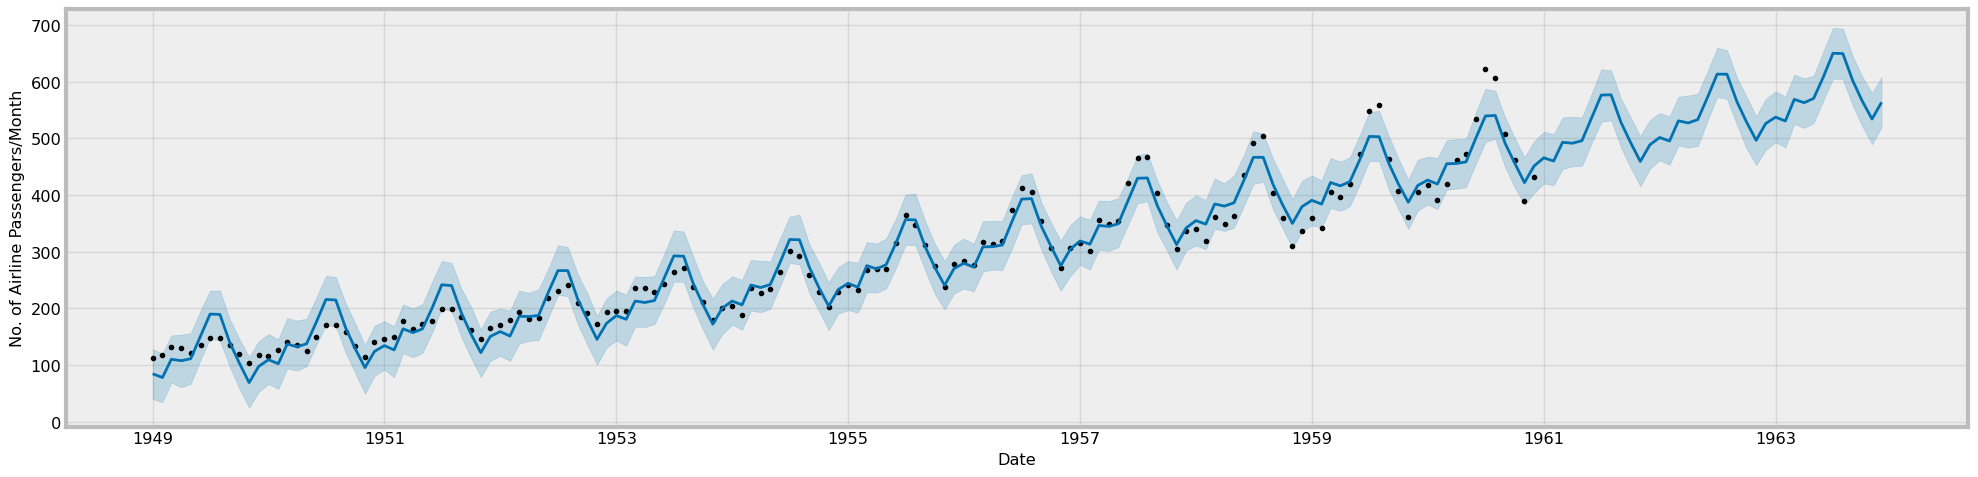

In [33]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast,
           uncertainty=True,plot_cap=True,
           xlabel='Date',
           ylabel='No. of Airline Passengers/Month',
           figsize=(20, 5))
plt.show()

Prophet plots the observed values of the time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly, and yearly patterns of the time series contribute to the overall forecasted values. We can use the `.plot_components()` method to view the individual components.

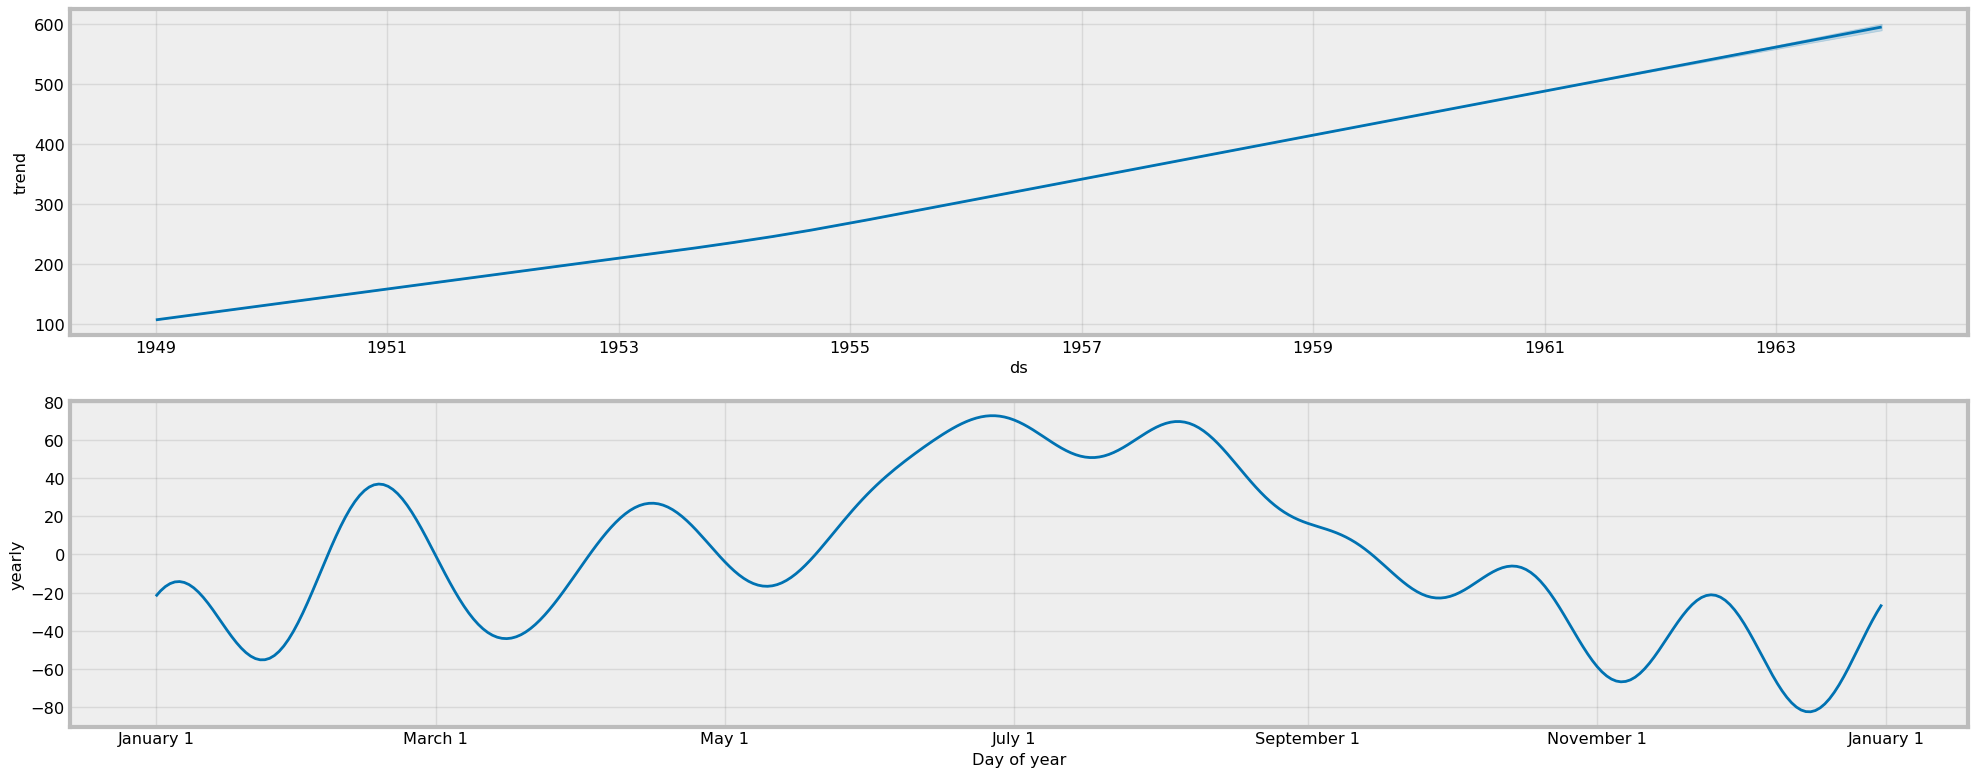

In [23]:
# Plot model components
Model.plot_components(forecast, figsize=(20, 8))
plt.show()

Since we are working with monthly data, Prophet will plot the trend and the yearly seasonality but if you were working with daily data, you would also see a weekly seasonality plot included. 

From the trend and seasonality, we can see that the trend is playing a large part in the underlying time series and seasonality comes into play mostly toward the beginning and the end of the year. With this information, we've been able to quickly model and forecast some data to get a feel for what might be coming our way in the future from this particular dataset. 

## Summary 
In this lab, you learned how to use the `fbprophet` library to perform time series forecasting in Python. We have been using out-of-the box parameters, but Prophet enables us to specify many more arguments. In particular, Prophet provides the functionality to bring your own knowledge about time series to the table.